# R data

In [1]:
u1_csv=r'..\data\haptic_data\flexible-haptic\user1_flexible-haptic_2025-03-27T16-04-54_112135.csv'
u2_csv=r'..\data\haptic_data\flexible-haptic\user3_flexible-haptic_2025-03-27T16-10-40_456602.csv'
u3_csv=r'..\data\haptic_data\flexible-haptic\user3_flexible-haptic_2025-03-27T16-45-29_971081.csv'
u4_csv=r'..\data\haptic_data\flexible-haptic\user4_flexible-haptic_2025-03-27T16-57-32_536460.csv'

u1_wav=r'../data/haptic_data/flexible-haptic/user1_flexible-haptic_2025-03-27T16-04-54_112135.wav'
u2_wav=r'../data/haptic_data/flexible-haptic/user3_flexible-haptic_2025-03-27T16-10-40_456602.wav'
u3_wav=r'../data/haptic_data/flexible-haptic/user3_flexible-haptic_2025-03-27T16-45-29_971081.wav'
u4_wav=r'../data/haptic_data/flexible-haptic/user4_flexible-haptic_2025-03-27T16-57-32_536460.wav'

# Pre data

# datastruct

- *audio_haptic # 200ms  150 play +50 buffer
- audio_haptic_spec 
- *audio_press  # 60 ms 
- audio_press_spec
- audio_press_mfcc
- *Inertial_press  # 60  fixed stgart  point 
- *Inertial_haptic  # 40   dynamic start point
- *Inertial_whole # can overlap 150 ?
- Audio_whole  # can overlap   300ms? 


- Rule
- Find the highest power 150ms, and extend to the left + 50ms , which is 200ms for the 
    - audio_haptic
    - Mark the start time  T1
- Find the left start from T1 boundary of the none,none,none,none,cross,cross,cross 
    - Mark the start time T2 
    - Based on the T2 at CSV go to left + 10 records ,mark the time T3
- From T3 go to right +60 records mark the inertial_press data( 60 records)
    - Inertial _press

- From T1 find the csv time +60 records 
    - inertial_haptic

- From T3 +150 records
    - Inertial_whole

- From T3 + 200 ms and then within 200ms find the average highest power 60ms 
    - Audio_press

- From T3 - end of the audio_haptic 
    - Audio_whole

ineritl_press 
inertial_press + press mfcc
inertial_press + hatpcic spec
inertial_whole + press mfcc + hatpci spec

In [38]:
import os
import re
import numpy as np
import librosa
import pandas as pd
from scipy.signal import find_peaks
from datetime import datetime, timedelta

def extract_start_timestamp_from_filename(filename):
    match = re.search(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', filename)
    if match:
        timestamp = match.group(0)
        date_part, time_part = timestamp.split('T')
        return f"{date_part}T{time_part.replace('-', ':')}"
    return None

def find_cross_start(df, start_idx):
    # Look to the left of the start index
    lookback_range = df.loc[:start_idx-1, 'button_press'][::-1]
    pattern = ['none', 'none', 'none', 'cross', 'cross', 'cross']
    buffer = []

    for idx, value in lookback_range.items():
        buffer.insert(0, value)
        if len(buffer) > len(pattern):
            buffer.pop()
        if buffer == pattern:
            return idx + len(buffer) - pattern[::-1].index('cross') - 1  # Return first 'cross' index
    return None  # Pattern not found

def prepare_audio_csv_segement(wav_path, csv_path, n_segments=100, segment_duration=0.15, pre_segment_duration=0.05):
    audio, sr = librosa.load(wav_path, sr=None)
    segment_length = int(segment_duration * sr)
    pre_segment_length = int(pre_segment_duration * sr)
    total_length = segment_length + pre_segment_length
    hop_length = segment_length // 4

    energy = librosa.feature.rms(y=audio, frame_length=segment_length, hop_length=hop_length, center=True)[0]
    peaks, _ = find_peaks(energy, distance=segment_length / hop_length)

    if len(peaks) < n_segments:
        additional = np.linspace(0, len(energy) - 1, n_segments - len(peaks), dtype=int)
        peaks = np.concatenate([peaks, additional])

    peak_samples = peaks * hop_length
    energies, valid_pos = [], []

    for pos in peak_samples:
        if pos + segment_length <= len(audio):
            segment = audio[pos:pos + segment_length]
            energies.append(np.mean(np.abs(segment)))
            valid_pos.append(pos)

    sorted_idx = np.argsort(energies)[::-1]
    audio_haptic, energy_values, selected_positions, used_ranges = [], [], [], []
    haptic_segment_timestamps, inertial_haptic, inertial_haptic_id = [], [], []
    inertial_whole, inertial_whole_id = [], []
    inertial_press, inertial_press_id = [], []
    audio_whole, audio_whole_timestamp = [], []
    audio_press, audio_press_timestamp = [], []

    file_start_timestamp = extract_start_timestamp_from_filename(os.path.basename(wav_path))
    df = pd.read_csv(csv_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    for idx in sorted_idx:
        pos = valid_pos[idx]
        start = max(0, pos - pre_segment_length)
        end = pos + segment_length

        if any(not (end <= u_start or start >= u_end) for u_start, u_end in used_ranges):
            continue

        haptic_segment = audio[start:end]
        if len(haptic_segment) < total_length:
            haptic_segment = np.pad(haptic_segment, (0, total_length - len(haptic_segment)))

        haptic_start_sec = start / sr
        haptic_timestamp = (
            (datetime.fromisoformat(file_start_timestamp) + timedelta(seconds=haptic_start_sec)).isoformat()
            if file_start_timestamp else f"{haptic_start_sec:.6f}"
        )

        audio_haptic.append(haptic_segment)
        energy_values.append(energies[idx])
        selected_positions.append((start, end))
        used_ranges.append((start, end))
        haptic_segment_timestamps.append(haptic_timestamp)

        try:
            target_time = pd.to_datetime(haptic_timestamp)
            closest_idx = (df['timestamp'] - target_time).abs().idxmin() + 40
            end_idx = min(closest_idx + 40, len(df))
            inertial_sample = df.iloc[closest_idx:end_idx].to_dict(orient='records')

            inertial_haptic.append(inertial_sample)
            inertial_haptic_id.append(closest_idx)

            # Find inertial_whole range
            cross_start_idx = find_cross_start(df, closest_idx) -10 # extend 10 records from the left
            if cross_start_idx is not None:
                inertial_whole_data = df.iloc[cross_start_idx:end_idx].to_dict(orient='records')
                inertial_whole.append(inertial_whole_data)
                inertial_whole_id.append(cross_start_idx)
                
                # Extract inertial_press (first 100 records from inertial_whole)
                press_end_idx = min(cross_start_idx + 100, len(df))
                inertial_press_data = df.iloc[cross_start_idx:press_end_idx].to_dict(orient='records')
                inertial_press.append(inertial_press_data)
                inertial_press_id.append(cross_start_idx)
                
                # Extract audio_whole from inertial_whole's first timestamp to the end of audio_haptic
                if len(inertial_whole_data) > 0:
                    whole_start_time = pd.to_datetime(inertial_whole_data[0]['timestamp'])
                    whole_start_sec = (whole_start_time - datetime.fromisoformat(file_start_timestamp)).total_seconds()
                    whole_start_sample = int(whole_start_sec * sr)
                    whole_audio_segment = audio[whole_start_sample:end]
                    audio_whole.append(whole_audio_segment)
                    audio_whole_timestamp.append(whole_start_time.isoformat())
                    
                    # Extract audio_press: find peak in first 300ms of audio_whole and extract 60ms around it
                    search_duration_ms = 300
                    search_samples = min(int(search_duration_ms / 1000 * sr), len(whole_audio_segment))
                    search_segment = whole_audio_segment[:search_samples]
                    
                    if len(search_segment) > 0:
                        # Find the peak amplitude in the search segment
                        peak_idx = np.argmax(np.abs(search_segment))
                        
                        # Extract 60ms around the peak (30ms before, 30ms after)
                        press_duration_ms = 60
                        half_press_samples = int((press_duration_ms / 2) / 1000 * sr)
                        press_start = max(0, peak_idx - half_press_samples)
                        press_end = min(len(whole_audio_segment), peak_idx + half_press_samples)
                        
                        press_segment = whole_audio_segment[press_start:press_end]
                        
                        # Ensure consistent length (60ms)
                        expected_press_samples = int(press_duration_ms / 1000 * sr)
                        if len(press_segment) < expected_press_samples:
                            press_segment = np.pad(press_segment, (0, expected_press_samples - len(press_segment)))
                        
                        # Calculate timestamp for audio_press
                        press_start_sec = whole_start_sec + (press_start / sr)
                        press_timestamp = (datetime.fromisoformat(file_start_timestamp) + 
                                          timedelta(seconds=press_start_sec)).isoformat()
                        
                        audio_press.append(press_segment)
                        audio_press_timestamp.append(press_timestamp)
                    else:
                        audio_press.append(np.array([]))
                        audio_press_timestamp.append(None)
                else:
                    audio_whole.append(np.array([]))
                    audio_whole_timestamp.append(None)
                    audio_press.append(np.array([]))
                    audio_press_timestamp.append(None)
            else:
                inertial_whole.append([])
                inertial_whole_id.append(None)
                inertial_press.append([])
                inertial_press_id.append(None)
                audio_whole.append(np.array([]))
                audio_whole_timestamp.append(None)
                audio_press.append(np.array([]))
                audio_press_timestamp.append(None)

        except Exception as e:
            inertial_haptic.append([])
            inertial_haptic_id.append(None)
            inertial_whole.append([])
            inertial_whole_id.append(None)
            inertial_press.append([])
            inertial_press_id.append(None)
            audio_whole.append(np.array([]))
            audio_whole_timestamp.append(None)
            audio_press.append(np.array([]))
            audio_press_timestamp.append(None)

        if len(audio_haptic) >= n_segments:
            break

    return {
        'audio_haptic': audio_haptic, # 200ms  
        'hap_timestamp': haptic_segment_timestamps,
        'energy_values': energy_values,
        'sampling_rate': sr,
        'file_start_timestamp': file_start_timestamp,
        'selected_positions': selected_positions,
        'full_audio': audio,
        'inertial_haptic': inertial_haptic, # 40 records  
        'inertial_haptic_id': inertial_haptic_id,
        'inertial_whole': inertial_whole, # dyanmaic range  
        'inertial_whole_id': inertial_whole_id,
        'inertial_press': inertial_press, # 100 records 
        'inertial_press_id': inertial_press_id,
        'audio_whole': audio_whole,  # dynamic range 
        'audio_whole_timestamp': audio_whole_timestamp,
        'audio_press': audio_press, # 60ms 
        'audio_press_timestamp': audio_press_timestamp,
    }


In [46]:
import matplotlib.pyplot as plt
import librosa.display

def plot_audio_haptic_segments(audio_haptic_data, max_plots=10):
    """
    Plot waveform and spectrogram of each audio_haptic segment, audio_press segment, and audio_whole segment.

    Args:
        audio_haptic_data (dict): Output from find_high_amplitude_segments_simple
        max_plots (int): Max number of segments to plot
    """
    audio_haptic = audio_haptic_data['audio_haptic']
    audio_press = audio_haptic_data['audio_press']
    audio_whole = audio_haptic_data['audio_whole']
    sr = audio_haptic_data['sampling_rate']
    energy_values = audio_haptic_data['energy_values']

    n_segments = len(audio_haptic)
    max_plots = min(max_plots or n_segments, n_segments)

    segments_per_row = 5
    n_rows = (max_plots + segments_per_row - 1) // segments_per_row

    # 6 rows per segment: haptic waveform, haptic spectrogram, press waveform, press spectrogram, whole waveform, whole spectrogram
    fig, axs = plt.subplots(n_rows * 6, segments_per_row, figsize=(20, 18 * n_rows))

    for i in range(max_plots):
        row_base = (i // segments_per_row) * 6
        col = i % segments_per_row

        # Plot haptic waveform
        axs[row_base, col].plot(audio_haptic[i], color='gray')
        axs[row_base, col].set_title(f"Haptic Waveform {i+1} (Energy: {energy_values[i]:.4f})")
        axs[row_base, col].set_xlabel("Samples")
        axs[row_base, col].set_ylabel("Amplitude")

        # Plot haptic spectrogram
        S_haptic = librosa.stft(audio_haptic[i])
        D_haptic = librosa.amplitude_to_db(np.abs(S_haptic), ref=np.max)
        img_haptic = librosa.display.specshow(D_haptic, sr=sr, y_axis='log', x_axis='time', ax=axs[row_base + 1, col])
        axs[row_base + 1, col].set_title(f"Haptic Spectrogram {i+1}")
        fig.colorbar(img_haptic, ax=axs[row_base + 1, col], format="%+2.0f dB")

        # Plot press waveform
        if i < len(audio_press) and len(audio_press[i]) > 0:
            axs[row_base + 2, col].plot(audio_press[i], color='blue')
            axs[row_base + 2, col].set_title(f"Press Waveform {i+1}")
            axs[row_base + 2, col].set_xlabel("Samples")
            axs[row_base + 2, col].set_ylabel("Amplitude")

            # Plot press spectrogram
            S_press = librosa.stft(audio_press[i])
            D_press = librosa.amplitude_to_db(np.abs(S_press), ref=np.max)
            img_press = librosa.display.specshow(D_press, sr=sr, y_axis='log', x_axis='time', ax=axs[row_base + 3, col])
            axs[row_base + 3, col].set_title(f"Press Spectrogram {i+1}")
            fig.colorbar(img_press, ax=axs[row_base + 3, col], format="%+2.0f dB")
        else:
            axs[row_base + 2, col].axis('off')
            axs[row_base + 3, col].axis('off')
            
        # Plot whole waveform
        if i < len(audio_whole) and len(audio_whole[i]) > 0:
            axs[row_base + 4, col].plot(audio_whole[i], color='green')
            axs[row_base + 4, col].set_title(f"Whole Waveform {i+1}")
            axs[row_base + 4, col].set_xlabel("Samples")
            axs[row_base + 4, col].set_ylabel("Amplitude")

            # Plot whole spectrogram
            S_whole = librosa.stft(audio_whole[i])
            D_whole = librosa.amplitude_to_db(np.abs(S_whole), ref=np.max)
            img_whole = librosa.display.specshow(D_whole, sr=sr, y_axis='log', x_axis='time', ax=axs[row_base + 5, col])
            axs[row_base + 5, col].set_title(f"Whole Spectrogram {i+1}")
            fig.colorbar(img_whole, ax=axs[row_base + 5, col], format="%+2.0f dB")
        else:
            axs[row_base + 4, col].axis('off')
            axs[row_base + 5, col].axis('off')

    # Hide unused subplots
    for i in range(max_plots, n_rows * segments_per_row):
        row_base = (i // segments_per_row) * 6
        col = i % segments_per_row
        for j in range(6):
            axs[row_base + j, col].axis('off')

    plt.tight_layout()
    plt.show()

def plot_full_audio_with_segments(audio_haptic_data):
    """
    Plot the full audio waveform with highlighted segments.
    
    Args:
        audio_haptic_data (dict): Output from prepare_audio_csv_segement
    """
    full_audio = audio_haptic_data['full_audio']
    sr = audio_haptic_data['sampling_rate']
    selected_positions = audio_haptic_data['selected_positions']
    energy_values = audio_haptic_data['energy_values']
    
    # Create time axis in seconds
    time = np.arange(len(full_audio)) / sr
    
    plt.figure(figsize=(20, 6))
    plt.plot(time, full_audio, color='gray', alpha=0.7)
    
    # Highlight each selected segment with a different color
    colors = plt.cm.rainbow(np.linspace(0, 1, len(selected_positions)))
    
    for i, ((start, end), color, energy) in enumerate(zip(selected_positions, colors, energy_values)):
        start_time = start / sr
        end_time = end / sr
        segment_time = np.arange(start, end) / sr
        segment_audio = full_audio[start:end]
        
        plt.plot(segment_time, segment_audio, color=color, linewidth=2)
        
        # Add vertical lines to mark segment boundaries
        plt.axvline(x=start_time, color=color, linestyle='--', alpha=0.7)
        plt.axvline(x=end_time, color=color, linestyle='--', alpha=0.7)
        
        # Add segment index and energy directly on the waveform
        mid_time = (start_time + end_time) / 2
        max_amp = np.max(segment_audio)
        plt.text(mid_time, max_amp, f"{i+1}\nE:{energy:.2f}", 
                 color=color, fontweight='bold', ha='center', va='bottom')
        
        # Add color range indicator
        plt.axhspan(min(segment_audio), max(segment_audio), 
                   xmin=(start_time/time[-1]), xmax=(end_time/time[-1]), 
                   color=color, alpha=0.1)
    
    plt.title('Full Audio Waveform with Highlighted Haptic Segments')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()

def plot_inertial_haptic_sequences_grid(result, max_plots=10):
    inertial_haptic = result.get('inertial_haptic', [])
    inertial_whole = result.get('inertial_whole', [])
    timestamps = result.get('hap_timestamp', [])
    
    gyro_fields = ['gyro_pitch', 'gyro_yaw', 'gyro_roll']
    acc_fields = ['acc_x', 'acc_y', 'acc_z']
    
    num_to_plot = min(max_plots, len(inertial_haptic))
    
    # Create a figure with two rows per segment - one for haptic and one for whole
    fig, axes = plt.subplots(num_to_plot * 2, 2, figsize=(14, 3 * num_to_plot * 2), squeeze=False)
    fig.suptitle("Inertial Haptic and Whole Segments", fontsize=16)
    
    for i in range(num_to_plot):
        # Plot inertial_haptic
        haptic_sequence = inertial_haptic[i]
        if not haptic_sequence or not all(field in haptic_sequence[0] for field in gyro_fields + acc_fields):
            print(f"Skipping haptic sequence {i} due to missing fields.")
            continue
        
        haptic_time_axis = list(range(len(haptic_sequence)))
        haptic_gyro_data = {field: [row[field] for row in haptic_sequence] for field in gyro_fields}
        haptic_acc_data = {field: [row[field] for row in haptic_sequence] for field in acc_fields}
        
        # Plot haptic gyroscope
        ax_haptic_gyro = axes[i*2, 0]
        for field in gyro_fields:
            ax_haptic_gyro.plot(haptic_time_axis, haptic_gyro_data[field], label=field)
        ax_haptic_gyro.set_title(f"Haptic Gyroscope (Segment {i+1})\n{timestamps[i]}")
        ax_haptic_gyro.set_xlabel("Sample index")
        ax_haptic_gyro.set_ylabel("Gyro")
        ax_haptic_gyro.legend()

        # Plot haptic accelerometer
        ax_haptic_acc = axes[i*2, 1]
        for field in acc_fields:
            ax_haptic_acc.plot(haptic_time_axis, haptic_acc_data[field], label=field)
        ax_haptic_acc.set_title(f"Haptic Accelerometer (Segment {i+1})\n{timestamps[i]}")
        ax_haptic_acc.set_xlabel("Sample index")
        ax_haptic_acc.set_ylabel("Accel")
        ax_haptic_acc.legend()
        
        # Plot inertial_whole
        if i < len(inertial_whole):
            whole_sequence = inertial_whole[i]
            if not whole_sequence or not all(field in whole_sequence[0] for field in gyro_fields + acc_fields):
                print(f"Skipping whole sequence {i} due to missing fields.")
                continue
            
            whole_time_axis = list(range(len(whole_sequence)))
            whole_gyro_data = {field: [row[field] for row in whole_sequence] for field in gyro_fields}
            whole_acc_data = {field: [row[field] for row in whole_sequence] for field in acc_fields}
            
            # Extract button_press data
            button_press_data = [1 if row.get('button_press') == 'cross' else 0 for row in whole_sequence]
            
            # Plot whole gyroscope
            ax_whole_gyro = axes[i*2+1, 0]
            for field in gyro_fields:
                ax_whole_gyro.plot(whole_time_axis, whole_gyro_data[field], label=field)
            
            # Add button press indicators to gyro plot
            for j, press in enumerate(button_press_data):
                if press == 1:  # If button press is 'cross'
                    ax_whole_gyro.axvspan(j-0.5, j+0.5, color='red', alpha=0.3)
            
            ax_whole_gyro.set_title(f"Whole Gyroscope (Segment {i+1})\n{timestamps[i]}")
            ax_whole_gyro.set_xlabel("Sample index")
            ax_whole_gyro.set_ylabel("Gyro")
            ax_whole_gyro.legend()

            # Plot whole accelerometer
            ax_whole_acc = axes[i*2+1, 1]
            for field in acc_fields:
                ax_whole_acc.plot(whole_time_axis, whole_acc_data[field], label=field)
            
            # Add button press indicators to acc plot
            for j, press in enumerate(button_press_data):
                if press == 1:  # If button press is 'cross'
                    ax_whole_acc.axvspan(j-0.5, j+0.5, color='red', alpha=0.3)
            
            # Add button press data as a separate line at the bottom of the plot
            if any(button_press_data):  # Only if there are any button presses
                ax_whole_acc.plot(whole_time_axis, 
                                 [min(whole_acc_data['acc_x'] + whole_acc_data['acc_y'] + whole_acc_data['acc_z']) - 50] * len(button_press_data), 
                                 'k-', alpha=0.3)  # Base line
                ax_whole_acc.plot(whole_time_axis, 
                                 [min(whole_acc_data['acc_x'] + whole_acc_data['acc_y'] + whole_acc_data['acc_z']) - 50 + press * 40 for press in button_press_data], 
                                 'r-', linewidth=2, label='Button Press')
            
            ax_whole_acc.set_title(f"Whole Accelerometer (Segment {i+1})\n{timestamps[i]}")
            ax_whole_acc.set_xlabel("Sample index")
            ax_whole_acc.set_ylabel("Accel")
            ax_whole_acc.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
    plt.show()



def plot_length_distributions(dataset):
    # Audio lengths in seconds
    sr = dataset['sampling_rate']
    audio_lengths = [len(segment) / sr for segment in dataset['audio_whole'] if isinstance(segment, np.ndarray)]

    # Inertial lengths in number of records
    inertial_lengths = [len(entry) for entry in dataset['inertial_whole'] if isinstance(entry, list)]

    # Plotting
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.hist(audio_lengths, bins=20, edgecolor='black')
    plt.title('Audio Whole Length Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    
    # Mark min and max for audio
    min_audio = min(audio_lengths)
    max_audio = max(audio_lengths)
    plt.axvline(min_audio, color='r', linestyle='--', label=f'Min: {min_audio:.2f}s')
    plt.axvline(max_audio, color='g', linestyle='--', label=f'Max: {max_audio:.2f}s')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(inertial_lengths, bins=20, edgecolor='black')
    plt.title('Inertial Whole Length Distribution')
    plt.xlabel('Number of Records')
    plt.ylabel('Count')
    
    # Mark min and max for inertial
    min_inertial = min(inertial_lengths)
    max_inertial = max(inertial_lengths)
    plt.axvline(min_inertial, color='r', linestyle='--', label=f'Min: {min_inertial}')
    plt.axvline(max_inertial, color='g', linestyle='--', label=f'Max: {max_inertial}')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [40]:
u1_d=prepare_audio_csv_segement(u1_wav,u1_csv)

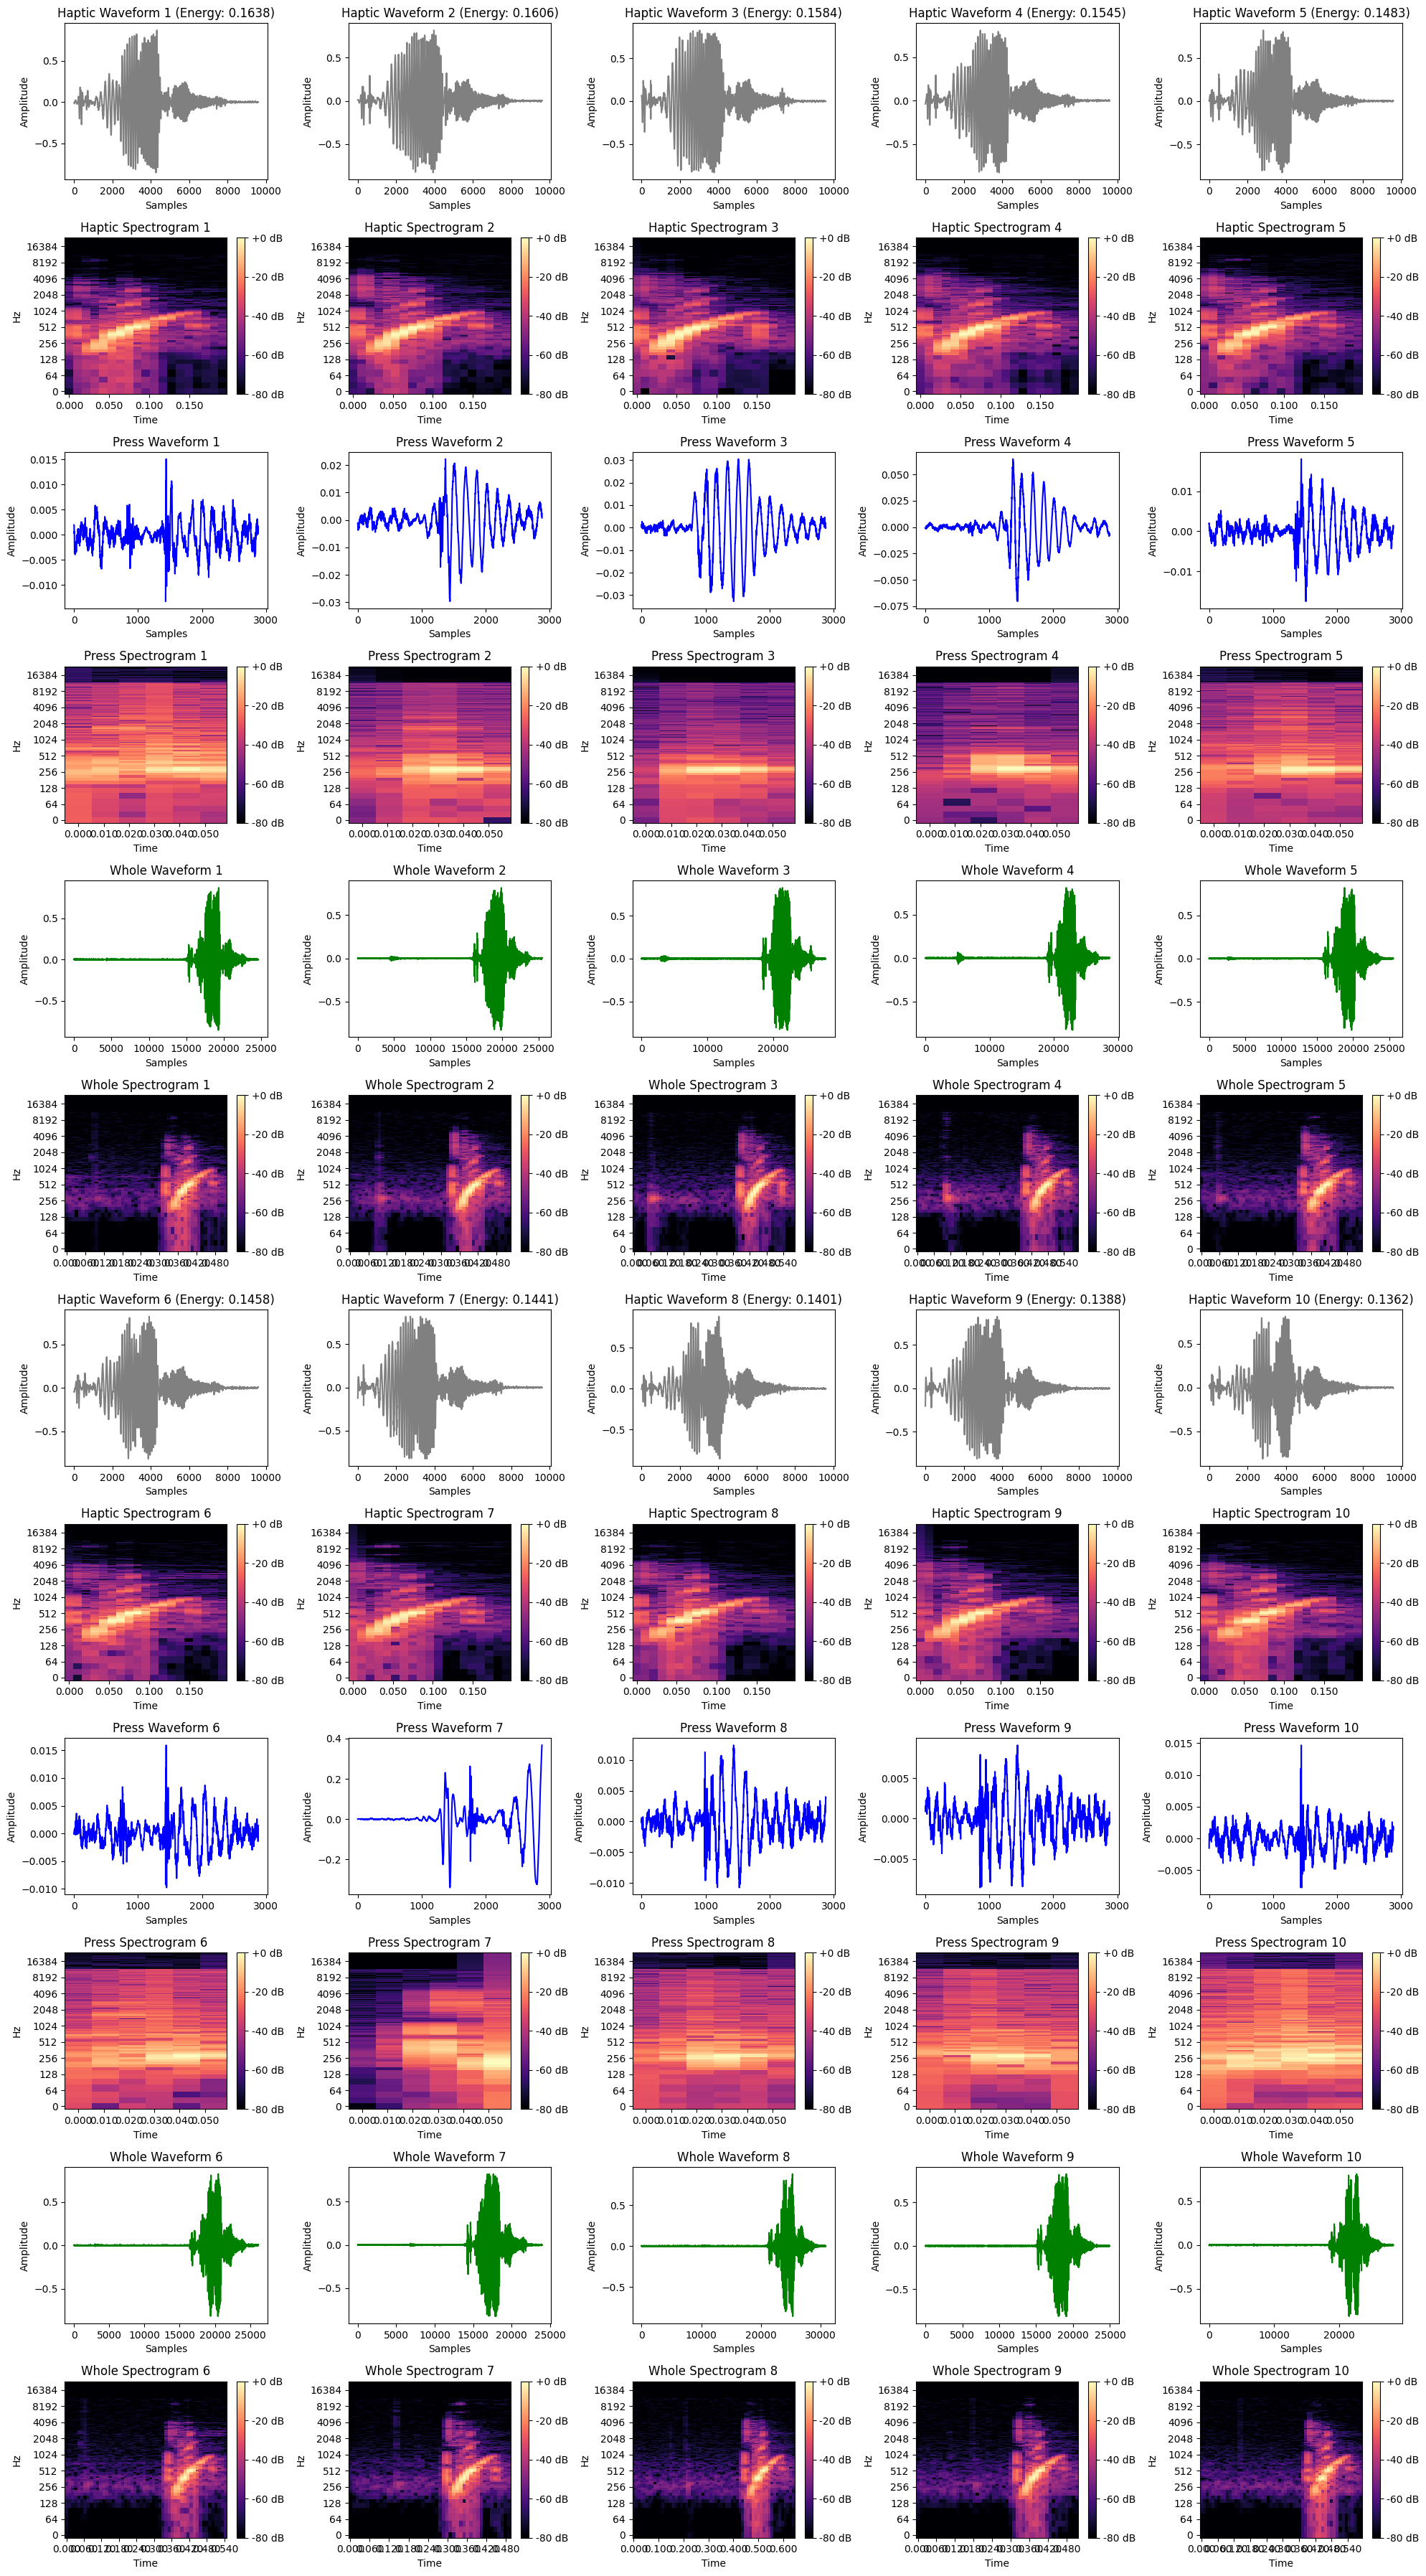

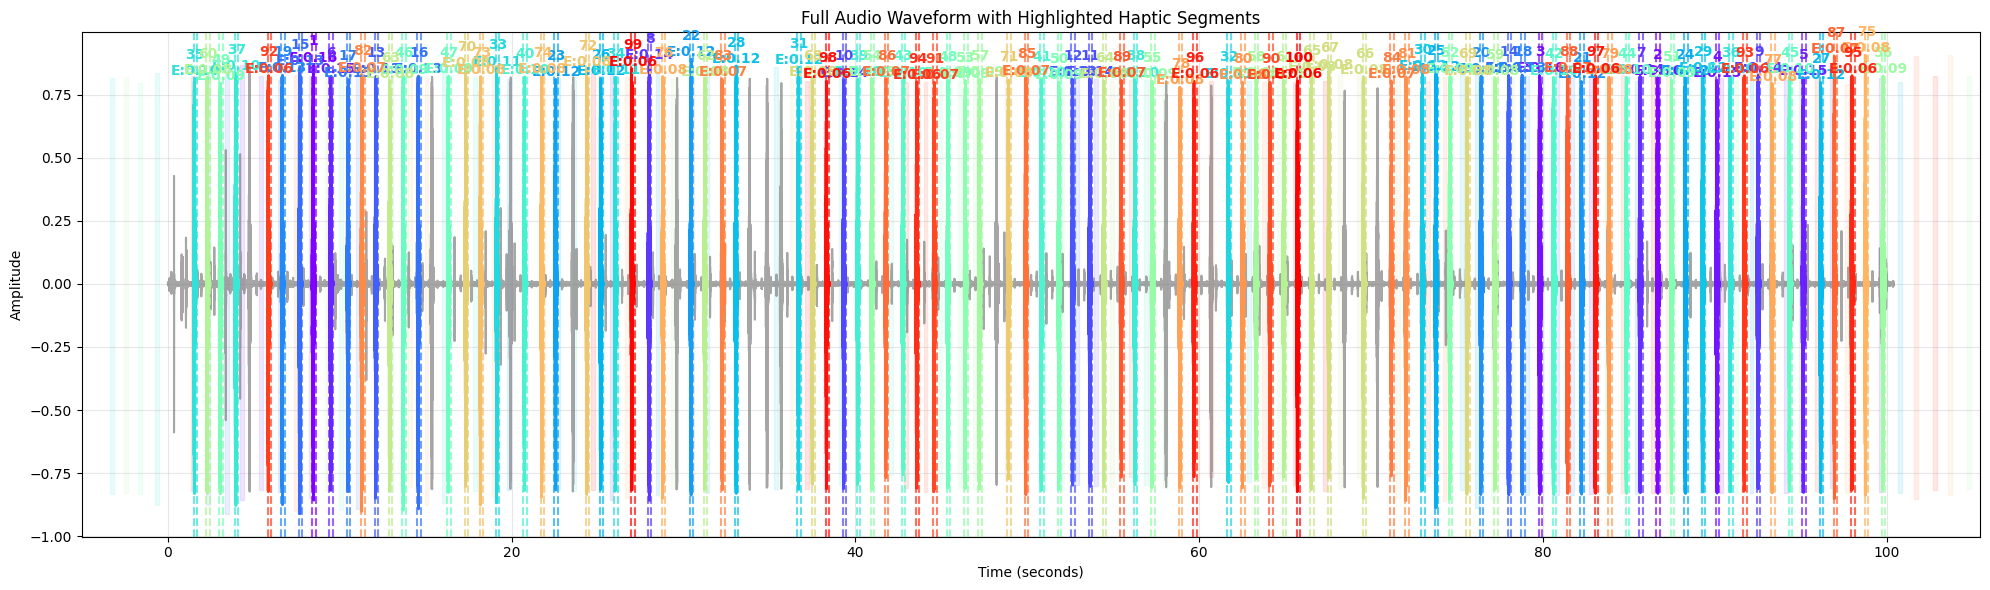

In [43]:
plot_audio_haptic_segments(u1_d)
plot_full_audio_with_segments(u1_d)

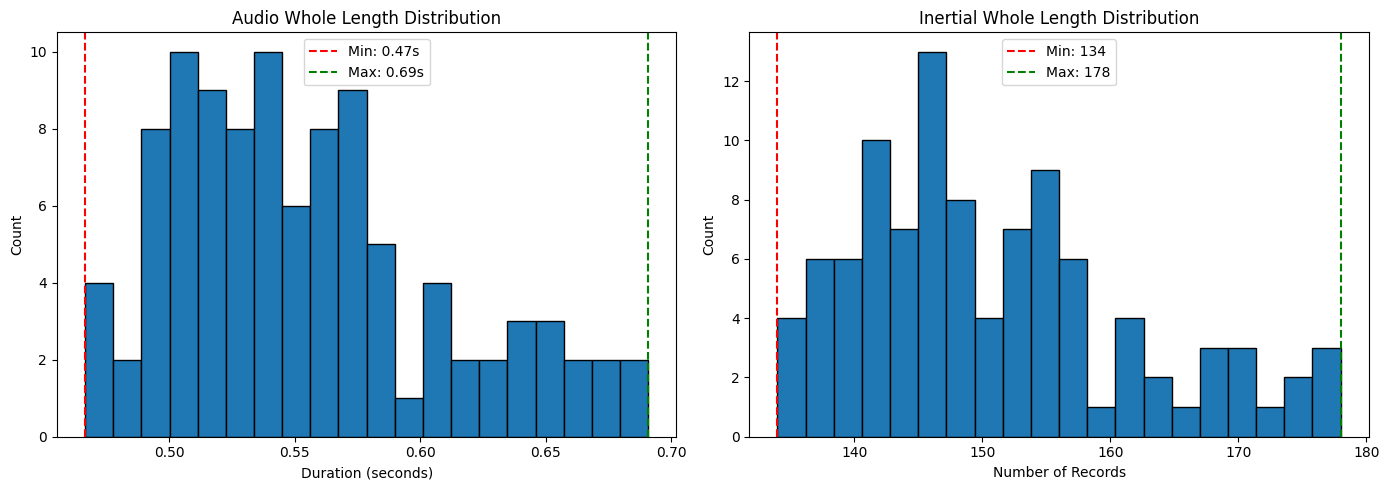

In [47]:
plot_length_distributions(u1_d)

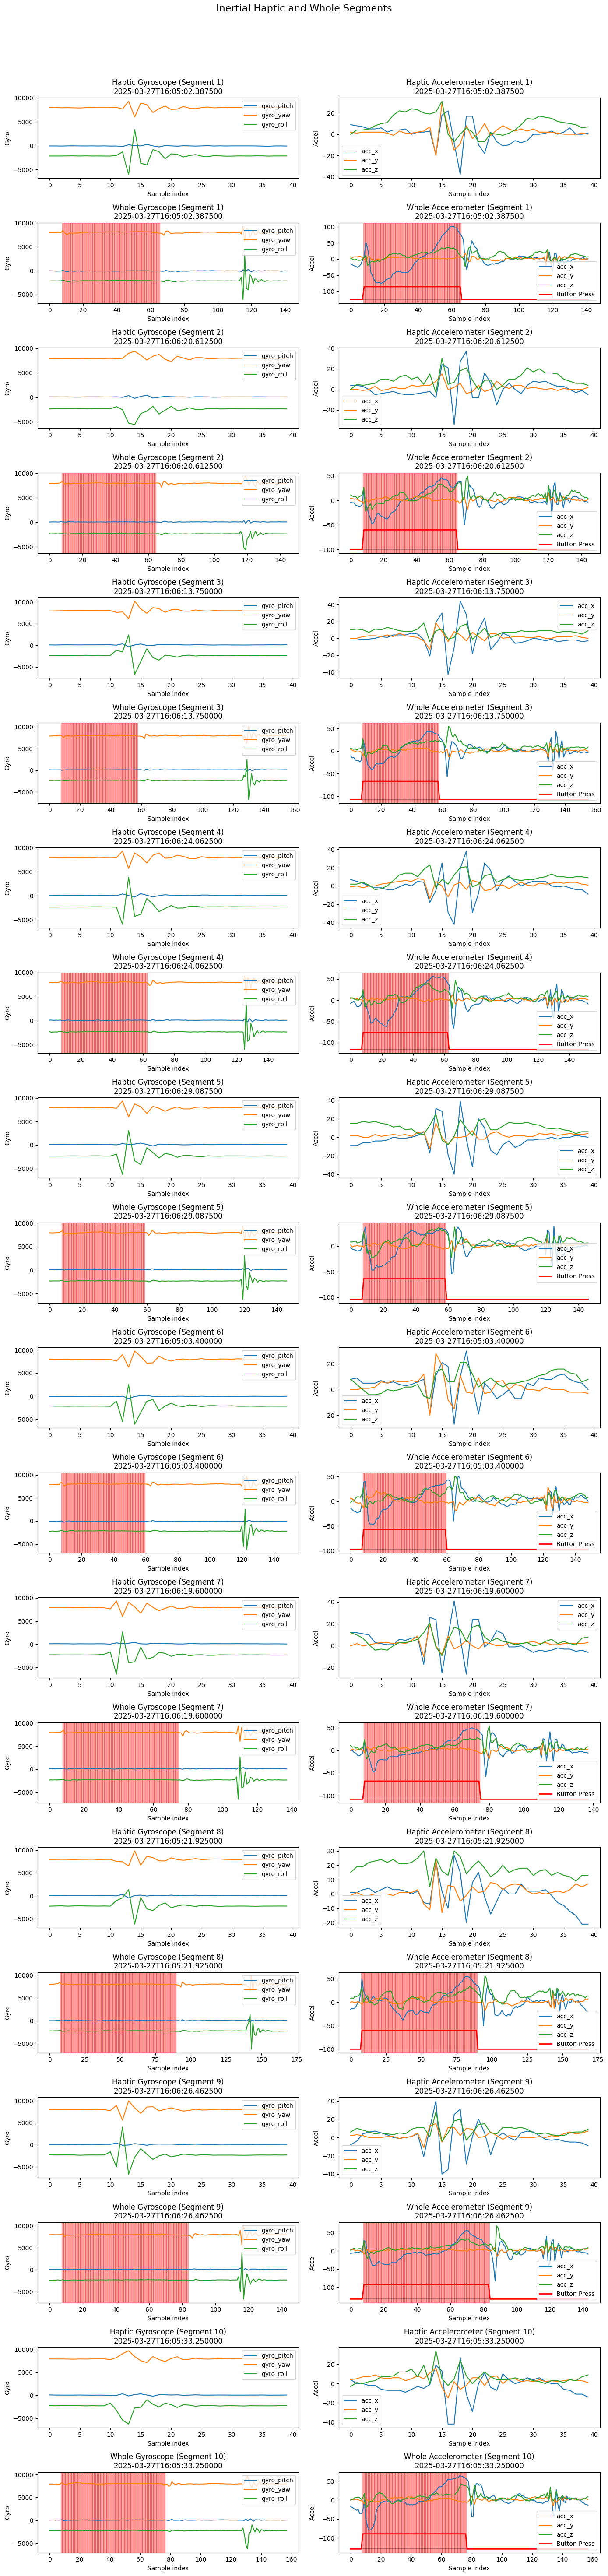

In [37]:
plot_inertial_haptic_sequences_grid(u1_d)